# Setup

In [10]:
import math
import warnings
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score



!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

C:\Users\nguye\miniconda3\Lib\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  res = process_handler(cmd, _system_body)
C:\Users\nguye\miniconda3\Lib\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  res = process_handler(cmd, _system_body)
C:\Users\nguye\miniconda3\Lib\site-packages\IPython\utils\_process_win32.py:138: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  res = process_handler(cmd, _system_body)


In [25]:
def save_df(df, name="temp"):
    """
    Saves the given DataFrame to a CSV file named '<name>.csv'
    """
    filename = f"{name}.csv"
    df.to_csv(filename, index=True)  # set index=False if you don't want to save the index
    print(f"Saved DataFrame to {filename}")

def clean_and_drop(X: pd.DataFrame, missing_threshold: float = 0.10) -> pd.DataFrame:
    missing_ratios = X.isnull().mean()
    to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
    print(f"Dropping columns due to missing data > {int(missing_threshold * 100)}%: {to_drop}")
    X = X.drop(columns=to_drop)

    before = len(X)
    X = X.dropna()
    after = len(X)
    print(f"Dropped {before - after} rows with any remaining NaNs.")

    return X

In [19]:
seed = 1234
warnings.filterwarnings('ignore')
diabetes_df = fetch_ucirepo(id=296)
#warnings.resetwarnings()

X = diabetes_df.data.features
y = diabetes_df.data.targets

# Clean and normalize the features
X = clean_and_drop(X, missing_threshold=0.05)
X = pd.get_dummies(X, drop_first=True)

# Switch label to binary classification
y = y.loc[X.index]
y = y.replace({'<30': 1, 'NO': 0, '>30': 0})

4783002
4110004
232165104


In [30]:
# First split: Train vs (Validation + Test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# Second split: Train vs Validation (from the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=seed)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Knn


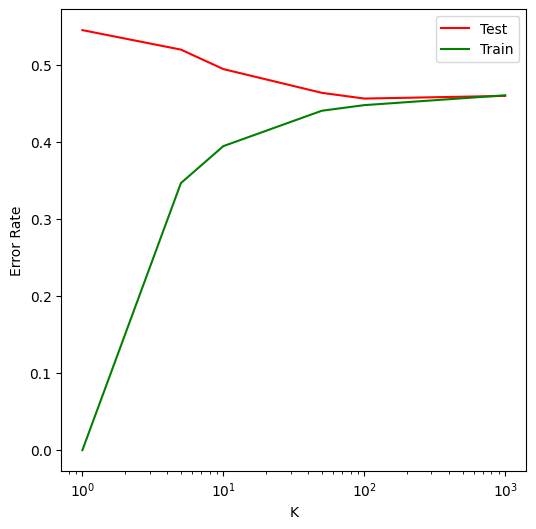

In [33]:
figure, axes = plt.subplots(1, figsize=(6, 6))
k_vals = [1, 5, 10, 50, 100, 1000]
axes.set_xlabel("K")
axes.set_ylabel("Error Rate")
te_error = []
tr_error = []
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train.values.ravel())
    y_pred_te = knn.predict(X_val_scaled)
    y_pred_tr = knn.predict(X_train_scaled)
    e_te = 1 - accuracy_score(y_val.values.ravel(), y_pred_te)
    e_tr = 1 - accuracy_score(y_train.values.ravel(), y_pred_tr)
    te_error.append(e_te)
    tr_error.append(e_tr)
axes.semilogx(k_vals, te_error, color='red', label='Test')
axes.semilogx(k_vals, tr_error, color='green', label='Train')
axes.legend()



In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

Use this to compare other classifers with lower sample sizes

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

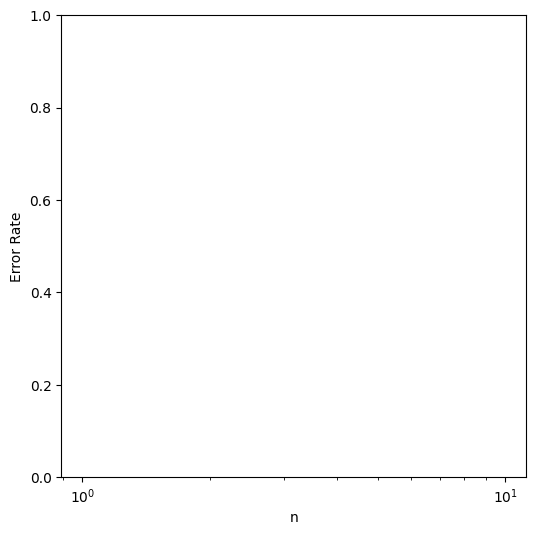

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=seed)
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

figure, axes = plt.subplots(1, figsize=(6, 6))

axes.set_xlabel("n")
axes.set_ylabel("Error Rate")
n = [100, 1000, 5000, 10000, 50000]
te_error = []
tr_error = []

for i, n in enumerate(n):
    knn = KNeighborsClassifier(n_neighbors=5)
    nX_tr, nX_te, ny_tr, ny_te = X_tr[:n], X_te[:n], y_tr[:n], y_te[:n]
    knn.fit(nX_tr, ny_tr)
    y_pred_te = knn.predict(nX_te)
    y_pred_tr = knn.predict(nX_tr)
    e_te = 1 - accuracy_score(ny_te, y_pred_te)
    e_tr = 1 - accuracy_score(ny_tr, y_pred_tr)
    te_error.append(e_te)
    tr_error.append(e_tr)
axes.semilogx(n, te_error, color='red', label='Test')
axes.semilogx(n, tr_error, color='green', label='Train')
axes.legend()